# Exploratory analisys and classification of EMG gestures captured by MYO Thalmic bracelet

#Summary

## In this notebook:
- **About the dataset**
    - Background
    - Data description
    - Source of dataset
- **Project**
    - Importing libraries
    - Loading data
    - Data analysis
    - Molding data
    - Developing CNN model
    - Model evaluation
    - **Bonus**: Optimized classifier with 4 channels of EEG
- **Conclusion**

        


# About the dataset


### Background

Electroencephalography (EEG) is a non-invasive method used to record electrical activity in the brain. By placing electrodes on the scalp, EEG captures the oscillatory patterns generated by neural activity, which are then amplified and digitized for analysis. This technique is widely used in both clinical and research settings to monitor brain function, diagnose neurological conditions such as epilepsy, and study cognitive processes. EEG is particularly valued for its high temporal resolution, allowing researchers to track changes in brain activity on the order of milliseconds. However, the spatial resolution of EEG is relatively low, as the recorded signals are an aggregate of electrical activity from large populations of neurons. Despite this limitation, EEG remains a powerful tool for exploring the dynamics of the brain in real time, offering insights into everything from sleep patterns to the neural correlates of sensory perception and motor control.

A collaborative project between CU Anschutz and ULN has focused on collecting EEG data from subjects as they engage in mental visualization of motor-based tasks. During these sessions, participants were instructed to visualize performing two types of tasks: one that was highly familiar to them and another that was unfamiliar. The primary objective of this study is to develop a classifier capable of accurately distinguishing between the EEG patterns associated with familiar and unfamiliar task visualizations. By analyzing the neural signatures captured during these sessions, the project aims to advance our understanding of how familiarity with a task influences brain activity and to create a reliable tool for identifying the nature of the task being visualized based on EEG data. This research has significant implications for fields such as neurorehabilitation, where understanding and enhancing motor imagery could play a critical role in recovery and training protocols.

### Data description
Each .csv file consist of 14 channels of EEG data. The end of the name of the file signifies if the file contains data of familiar (KS) or unfamiliar (US)movement brain state.
    
### Source of dataset

The source of is [EEG-Classification project by Tevis Gehr](https://github.com/tevisgehr/EEG-Classification), a collaboration with Nebraska Athetic Performance Lab at University of Nebraska and University of Colorado Anschutz.

This project seeks to improve upon his work.

#Project

##Importing libraries

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
import seaborn as sns

from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

import scipy.stats as stats

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D
from tensorflow.keras.callbacks import EarlyStopping

##Loading data

In [46]:
def load_csv_file(file_name):
    data = genfromtxt(file_name, delimiter=',').T
    return data

def load_data_to_dataframe(file_names, labels):
    all_data = []
    for file_name, label in zip(file_names, labels):
        data = load_csv_file(file_name)
        df = pd.DataFrame(data)
        df['label'] = label
        all_data.append(df)

    final_df = pd.concat(all_data, ignore_index=True)
    return final_df

file_names = ['data/ML101_KS.csv', 'data/ML101_US.csv', 'data/ML102_KS.csv', 'data/ML102_US.csv',
              'data/ML103_KS.csv', 'data/ML103_US.csv', 'data/ML104_KS.csv', 'data/ML104_US.csv',
              'data/ML105_KS.csv', 'data/ML105_US.csv', 'data/ML106_KS.csv', 'data/ML106_US.csv',
              'data/ML107_KS.csv', 'data/ML107_US.csv', 'data/ML108_KS.csv', 'data/ML108_US.csv']
labels = [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]

df = load_data_to_dataframe(file_names, labels)

In [47]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,label
0,-78.03,-75.99,-88.74,-87.21,-53.04,-64.77,-69.87,-80.07,-72.42,-68.85,-77.01,-69.87,-102.00,-116.79,1
1,-79.56,-77.01,-92.82,-93.84,-54.57,-65.79,-82.62,-93.33,-71.91,-78.03,-76.50,-59.67,-97.41,-121.38,1
2,-77.52,-77.01,-92.31,-89.76,-78.54,-59.16,-76.50,-75.99,-84.66,-61.71,-80.58,-71.91,-102.00,-139.23,1
3,-78.54,-73.44,-87.21,-81.60,-67.83,-59.16,-74.46,-67.83,-85.17,-55.08,-83.64,-83.13,-99.96,-136.17,1
4,-74.46,-64.26,-81.09,-75.48,-57.63,-62.73,-75.48,-75.48,-73.44,-62.73,-84.15,-79.56,-92.31,-128.52,1


##Data analysis

In [48]:
df.isnull().values.any() #Checking for null values

False

In [49]:
df["label"].unique() #Checking for number of classes

array([1, 0])

In [50]:
df.describe().transpose() #Information about dataset

,count,mean,std,min,25%,50%,75%,max
0,235136.0,-66.221403,147.488465,-2989.6,-83.64,-71.91,-56.61,3375.20
1,235136.0,-66.679791,161.347970,-3262.0,-85.17,-71.91,-55.08,3404.80
2,235136.0,-67.679272,142.346434,-2876.4,-83.13,-72.93,-58.65,3342.50
3,235136.0,-72.480198,35.386135,-453.9,-93.33,-73.44,-57.63,405.96
4,235136.0,-66.473168,160.886146,-3249.7,-84.66,-71.40,-54.06,3406.80
5,235136.0,-64.980855,153.321158,-3078.4,-85.68,-70.89,-52.02,3407.30
6,235136.0,-65.488746,157.772646,-3226.3,-80.58,-71.91,-58.65,3404.20
7,235136.0,-66.359180,157.378482,-3219.6,-84.66,-71.91,-55.59,3397.10
8,235136.0,-65.124912,159.163393,-3232.9,-81.09,-71.40,-57.63,3404.80
9,235136.0,-66.827697,172.237911,-3284.4,-79.56,-66.81,-56.61,3420.60


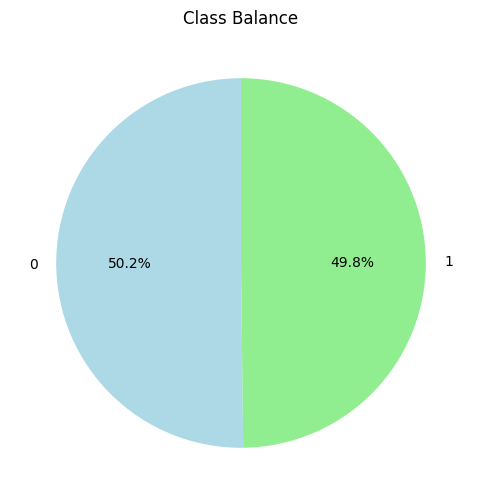

Number of samples from label no. 0 action:  118016 (50.19%)
Number of samples from label no. 1 action:  117120 (49.81%)


In [51]:
# Calculate the number of samples for each class
num_obs = len(df)
label_counts = df['label'].value_counts()

# Plot of class balance as a pie chart
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen'])
plt.title('Class Balance')
plt.show()

# Print numerical breakdown
for label, count in label_counts.items():
    print(f"Number of samples from label no. {label} action:  {count} ({(count/num_obs) * 100:2.2f}%)")

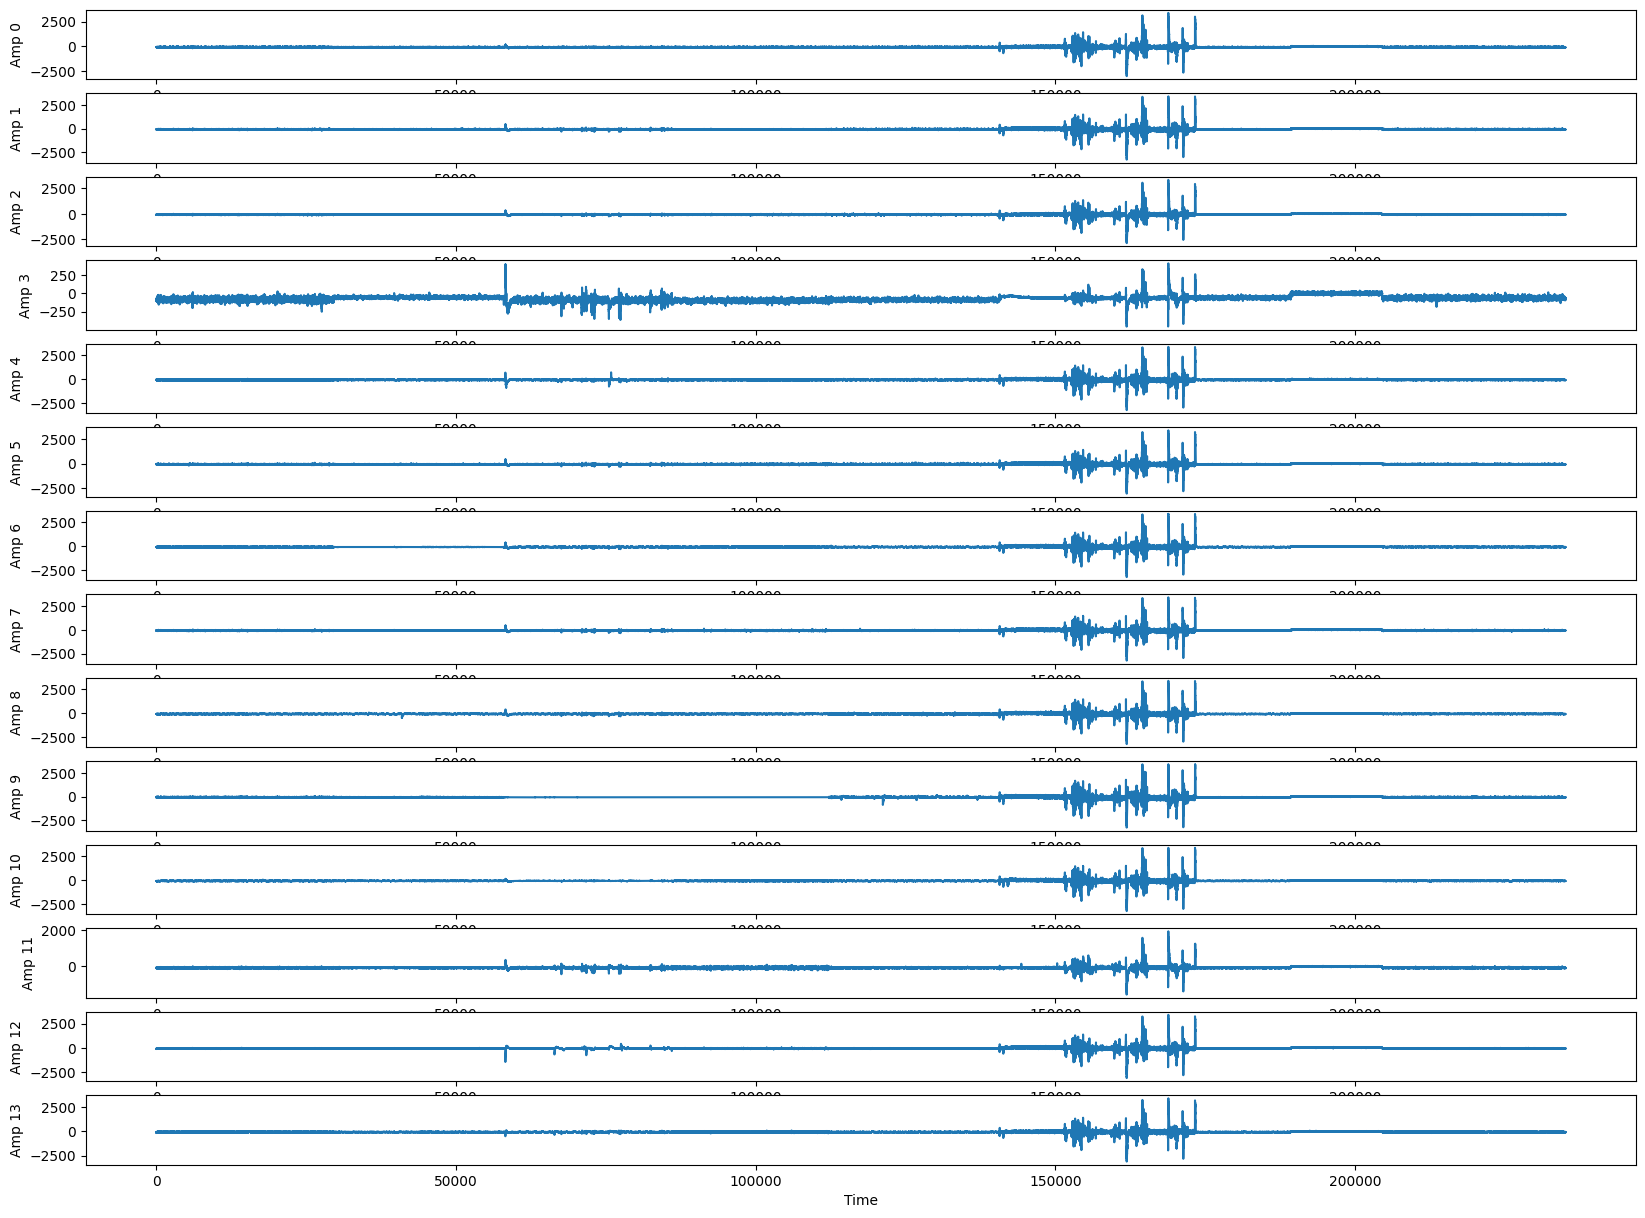

In [52]:
#Plotting 14 channels of EEG data
fig, axs = plt.subplots(14, 1, figsize=(20,15))

for i, ax in enumerate(fig.axes):
    ax.plot(df.iloc[:,i])
    ax.set_xlabel('Time')
    ax.set_ylabel(f'Amp {i}')

plt.show()

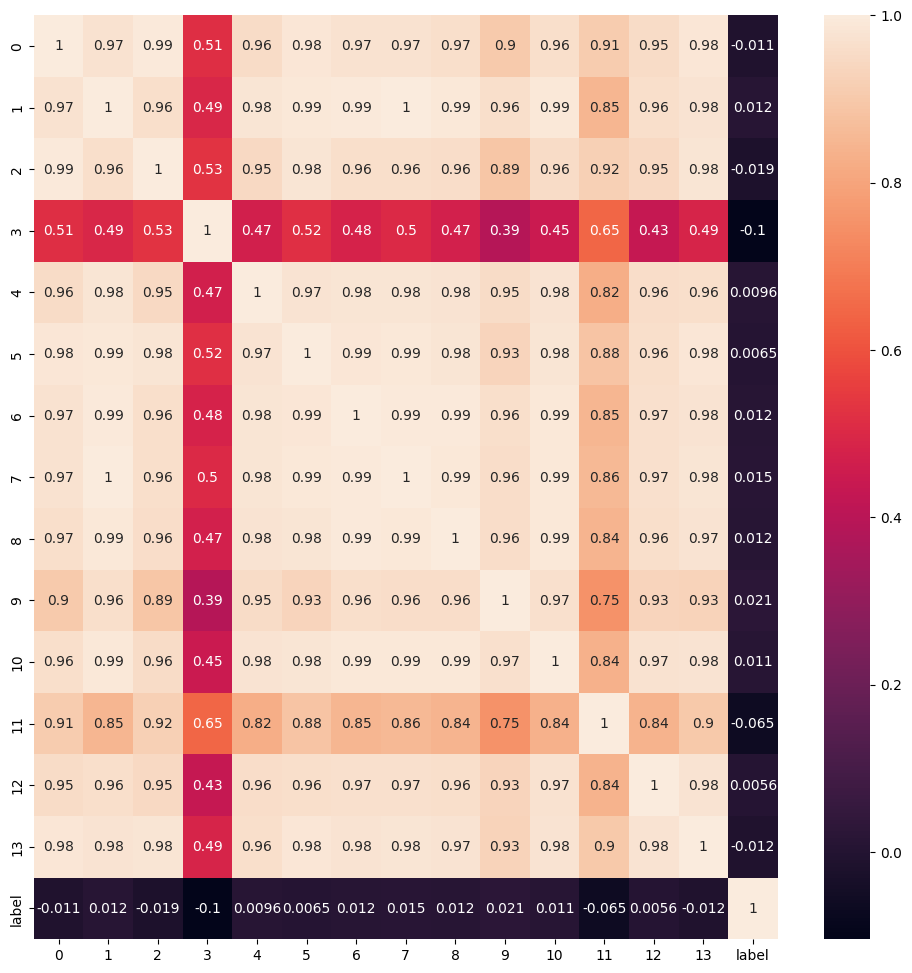

In [53]:
#Correlation
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(),annot=True)
plt.show()

**Interpretation**: The EEG data exhibits a high degree of correlation between channels, indicating that the recorded brain activity is consistent across the different electrode sites. However, it appears that Channel 3 may be compromised by noise, likely due to a suboptimal connection of the EEG electrode, which could affect the quality of the data from this channel. Despite this issue, the overall dataset is clean, with all necessary labels present and well-balanced across different classes. There is no need for additional balancing of the data, allowing for straightforward analysis and modeling efforts without the concern of class imbalance skewing the results.

## Molding data

In [54]:
scaler = StandardScaler()
channels = [i for i in range(14)]
df[channels] = scaler.fit_transform(df[channels])

In [55]:
sampling = 180 # frequency of sampling, in Hz
t_frame = 1 # time of one frame, in s
t_hop = 0.01 # shift between frames, in s
frame_size = int(sampling * t_frame) # number of samples per frame
hop_size = int(sampling * t_hop) # numer of sample shift per step

frames_list = []
classes_list = []
for i in range(0, len(df) - frame_size, hop_size):
    channels_frame = []
    for channel in channels:
        channels_frame.append(df[channel].values[i:i + frame_size])
    action = stats.mode(df["label"][i:i + frame_size], keepdims=True)[0][0]
    frames_list.append(channels_frame)
    classes_list.append(action)

frames = np.asarray(frames_list).reshape(-1, frame_size, 14)
classes = np.asarray(classes_list)

In [56]:
print("Number of frames: " + str(len(frames)))
print("Number of labels: " + str(len(classes)))

Number of frames: 234956
Number of labels: 234956


In [57]:
X = frames
y = classes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=31)

In [58]:
print(X_train.shape)
print(X_test.shape)

(187964, 180, 14)
(46992, 180, 14)


In [59]:
X_train = X_train.reshape(*X_train.shape, 1)
X_test = X_test.reshape(*X_test.shape, 1) # needs to be reshaped this way if we are to feed it to our model

## Developing CNN model

In [60]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(2,2),input_shape=X_train[0].shape, activation='relu'))
model.add(Dropout(0.5)) # I am using agressive dropout to avoid overfitting

model.add(Conv2D(filters=32, kernel_size=(2,2),input_shape=X_train[0].shape, activation='relu'))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))

# There are 7 neurons instead of 6, as I've decided to get rid of class 0 and keep labels as is (1-6).
# The reason behind this is that I wanted to keep classes in sync with documentation
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [61]:
results = model.fit(X_train, y_train, epochs=30, callbacks=[early_stop],
                    validation_data=(X_test, y_test), verbose=0)

Epoch 1/30
5874/5874 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.6697 - loss: 0.5652 - val_accuracy: 0.8455 - val_loss: 0.3045
Epoch 2/30
5874/5874 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.7953 - loss: 0.3844 - val_accuracy: 0.8420 - val_loss: 0.2999
Epoch 3/30
5874/5874 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8153 - loss: 0.3534 - val_accuracy: 0.8533 - val_loss: 0.2715
Epoch 4/30
5874/5874 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8287 - loss: 0.3306 - val_accuracy: 0.8853 - val_loss: 0.2308
Epoch 5/30
5874/5874 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.8354 - loss: 0.3218 - val_accuracy: 0.8887 - val_loss: 0.2270
Epoch 6/30
5874/5874 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.8429 - loss: 0.3072 - val_accuracy: 0.8989 - val_loss: 0.2108
Epoch 7/30
5874/5874 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8497 - loss: 0.2941 - val_accuracy: 0.9079 - val_loss: 0.1975
Epoch 8/30
5874/5874 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8555 - loss: 0

## Model evaluation

<Axes: >

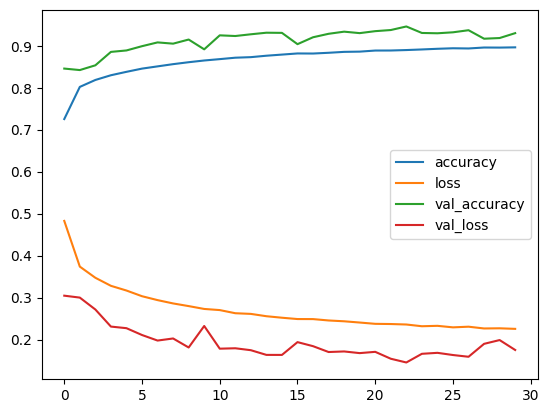

In [62]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [24]:
predictions_test = model.predict(X_test)

1469/1469 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [63]:
predictions_test_binary = (predictions_test >= 0.5).astype(int)
accuracy = accuracy_score(y_test, predictions_test_binary)

print("Accuracy on testing data: {0:.2f}%".format(100 * accuracy))

Accuracy on testing data: 93.54%


**Interpretation**: The model has been fitted and is predicting well. With almost 94% accuracy. The question that might be asked is "if the channels are correlated so much, could we make a model with less channels?". This is worth exploring as EEG equipment can be expensive. In the next example I will attempt to create a similiar classifier model based on only 4 channels instead of 14.

## Optimized classifier with 4 channels of EEG

In [67]:
sampling = 180 # frequency of sampling, in Hz
t_frame = 1 # time of one frame, in s
t_hop = 0.01 # shift between frames, in s
frame_size = int(sampling * t_frame) # number of samples per frame
hop_size = int(sampling * t_hop) # numer of sample shift per step

channels_opt = [0, 1, 2, 3]
frames_list_opt = []
classes_list_opt = []
for i in range(0, len(df) - frame_size, hop_size):
    channels_frame = []
    for channel in channels_opt:
        channels_frame.append(df[channel].values[i:i + frame_size])
    action = stats.mode(df["label"][i:i + frame_size], keepdims=True)[0][0]
    frames_list_opt.append(channels_frame)
    classes_list_opt.append(action)

frames_opt = np.asarray(frames_list_opt).reshape(-1, frame_size, 4)
classes_opt = np.asarray(classes_list_opt)

In [68]:
print("Number of frames: " + str(len(frames_opt)))
print("Number of labels: " + str(len(classes_opt)))

Number of frames: 234956
Number of labels: 234956


In [69]:
X_opt = frames_opt
y_opt = classes_opt

X_opt_train, X_opt_test, y_opt_train, y_opt_test = train_test_split(X_opt, y_opt, test_size=0.2, stratify=y_opt, random_state=31)

In [31]:
print(X_opt_train.shape)
print(X_opt_test.shape)

(187964, 180, 2)
(46992, 180, 2)


In [70]:
X_opt_train = X_opt_train.reshape(*X_opt_train.shape, 1) # needs to be reshaped this way if we are to feed it to our model
X_opt_test = X_opt_test.reshape(*X_opt_test.shape, 1)

In [71]:
model_opt = Sequential()

model_opt.add(Conv2D(filters=16, kernel_size=(2,2),input_shape=X_opt_train[0].shape, activation='relu'))
model_opt.add(Dropout(0.5)) # I am using agressive dropout to avoid overfitting

model_opt.add(Conv2D(filters=32, kernel_size=(2,2),input_shape=X_opt_train[0].shape, activation='relu'))
model_opt.add(Dropout(0.5))

model_opt.add(Flatten())

model_opt.add(Dense(64, activation="relu"))
model_opt.add(Dropout(0.5))

# There are 7 neurons instead of 6, as I've decided to get rid of class 0 and keep labels as is (1-6).
# The reason behind this is that I wanted to keep classes in sync with documentation
model_opt.add(Dense(1, activation="sigmoid"))

model_opt.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [72]:
results = model_opt.fit(X_opt_train, y_train, epochs=30, callbacks=[early_stop],
                    validation_data=(X_opt_test, y_opt_test), verbose=0)

<Axes: >

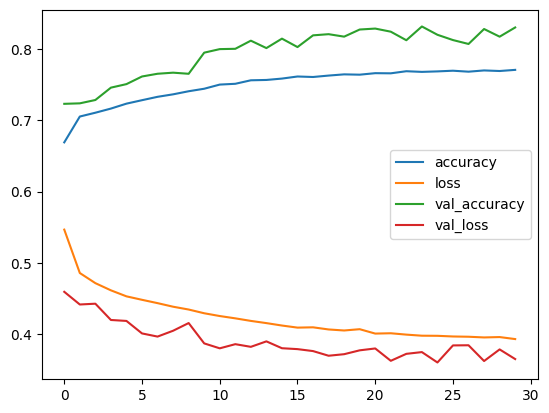

In [73]:
losses = pd.DataFrame(model_opt.history.history)
losses.plot()

In [74]:
predictions_test_opt = model_opt.predict(X_opt_test)

1469/1469 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [75]:
predictions_test_opt_binary = (predictions_test_opt >= 0.5).astype(int)
accuracy_opt = accuracy_score(y_opt_test, predictions_test_opt_binary)

print("Accuracy on testing data: {0:.2f}%".format(100 * accuracy_opt))

Accuracy on testing data: 82.99%


**Interpretation**: The model has learned well but seems to do a little worse. In the end having more equipment seems to be worth it.

# Conclusion

The data has been loaded, molded into the right format and trained upon. Simple CNN model has done well and after 30 epochs reached almost **94% accuracy**. This is an improvment of Mr. Tevis Gehr project which reached 85% accuracy. In his words:



> This is likely high enough to enable a new level of performance with brain-computer interface (BCI) technologies.

> However, the best results were obtained when the network was trained on samples from the same recording session. While this may be practical for basic brain research, it would be less practical for use in BCI technology.

Regarding optimization, the reduced amount of channels to 4 gave a result of just 83% accuracy. This is still promising result, as it shows there are clear tendencies but some information seems to be a lost or harder to access. Further work upon this concept could be done by changing hyper parameters or number of training epochs of the model. However, for my purposes this is good enough.